In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import numpy as np
from datetime import datetime, timedelta
import tqdm
import torch
import random
from scipy import stats
import math
import plotly.graph_objects as go


In [2]:
def indices_in_full_stamps(small,full):
    indices = np.full(len(full),False)
    for value in small:
        indices[full == value] = True
    return indices
def correlation(data, sim):
    return torch.correlation(data, sim)
import sys
def tolerant_mean(arrs,arrs_stamps,time_stamps):
     
    arr = np.ma.empty((len(time_stamps),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        x = np.array(arrs_stamps[idx])
        y =np.array(time_stamps)
        indices = indices_in_full_stamps(x,y)
        arr[indices,idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)
def decoding_frames(frame,idx_vid):
    

    try:
        start_cell = 5
        minimum = np.min(frame['Response'][start_cell:-1].fillna(method='ffill').values.astype(int))
        maximum = np.max(frame['Response'][start_cell:-1].fillna(method='ffill').values.astype(int))
    except:
        start_cell = 6
        minimum = np.min(frame['Response'][start_cell:-1].fillna(method='ffill').values.astype(int))
        maximum = np.max(frame['Response'][start_cell:-1].fillna(method='ffill').values.astype(int))
    start = datetime.fromtimestamp(frame['UTC Timestamp'][start_cell]/1000)
    times =[datetime.fromtimestamp(a) for a in frame['UTC Timestamp'][start_cell:-1]/1000]
    deltas = np.array([(time - start).seconds for time in times])
    start = 0
    surprise_values = [50]
    m = 0
    surprise = 0
    for time_step in range(max_idx * 2):
        active_steps = (time_step <= deltas) * (deltas  < time_step + 1)
        step_surprises = frame['Response'][start_cell:-1].fillna(method='ffill').values.astype(int)[active_steps]
        if len(step_surprises) > 0:
            surprise_values += [np.mean(step_surprises)]
        else:
            surprise_values += [surprise_values[-1]]
    return 0.5 * (torch.tensor(surprise_values[:-1:2]) + torch.tensor(surprise_values[1::2])).float()[2:]
def mean_surprise(data, cp, window):
    prior = data[cp-window:cp]
    posterior = data[cp:cp+window]
    return torch.mean(prior), torch.mean(posterior)
def computes_correlation(data,simulations):
    max_to_corr = min(len(simulations['surprise']),len(simulations['no_surprise']),len(data))
    if max_to_corr == 57:
        min_to_corr = 0
    else:
        min_to_corr = 0
    to_coeff = torch.zeros((3,max_to_corr-min_to_corr))

    to_coeff[0] = torch.Tensor(data[min_to_corr:max_to_corr])
    to_coeff[1] = simulations['surprise'][min_to_corr:max_to_corr]
    to_coeff[2] = simulations['no_surprise'][min_to_corr:max_to_corr]
#     if torch.sum(torch.corrcoef(to_coeff)==torch.corrcoef(to_coeff)) != 9:
#         fig, ax1 = plt.subplots()
#         ax2 = ax1.twinx()
#         ax1.plot(data)
#         ax2.plot(to_coeff[1],'g')
#         ax2.plot(to_coeff[2],'r')
#         plt.show()
    return torch.corrcoef(to_coeff)[0,1],torch.corrcoef(to_coeff)[0,2]
def average_subjects(frames,max_idx, questionnaires,simulations, plot = False):
    
    surprises = []
    correlations = torch.zeros((2))
    no_surprises = []
    before_surprises = []
    after_surprises = []
    window = int(max_idx / 4)
    for frame_idx in range(len(frames)):
        frame = frames[frame_idx]
        surprise_values = decoding_frames(frame, idx_vid)
        surprise_values = (surprise_values - torch.mean(surprise_values[:cp])) / torch.std(surprise_values)
        prior, posterior = mean_surprise(surprise_values, cp, window)
        
        before_surprises += [prior]
        after_surprises += [posterior]
        
        accepted, answer1, answer2, answer3 = questionnaire_check(questionnaires[frame_idx])
#         if accepted:
#             correlation_to_surprise, correlation_to_no_surprise = computes_correlation(surprise_values, simulations)
#             if correlation_to_surprise != correlation_to_surprise:
#                 accepted = False
        surprises.append(surprise_values[:max_idx].view(1, -1))
#         correlations[0] += correlation_to_surprise
#         correlations[1] += correlation_to_no_surprise
#         else:
#             print('Rejecting Subject N {}'.format(frame_idx+1))
#             print('Answers:',answer1,answer2,answer3 )
#             plt.plot(surprise_values)
#             plt.title('results subject {0}, {1}'.format(frame_idx+1,type_))
#             plt.show()
        if plot:
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ax1.plot(surprise_values)
            x = np.linspace(0, max_idx,len(simulations['surprise']))
            ax2.plot(simulations['surprise'],'k')
            x = np.linspace(0, max_idx,len(simulations['no_surprise']))
            ax2.plot(simulations['no_surprise'],'g')
            plt.title('results subject {0}, {1}'.format(frame_idx,type_))
            plt.show()
    correlations /= len(surprises)
    return torch.cat(surprises,dim = 0), before_surprises, after_surprises
def third_factor(x,theta = 0.04, eta1  = 5.19e-06, eta2  = 0.01142671):
            return 100 * (eta1 * torch.tanh((x)) + eta2 * \
                    torch.tanh(x) * (x >= theta).float())  * (x > 0).float()
def questionnaire_check(frame):
    sub_cond = {'no':0,'yes':1}
    idx1 = frame['Question Key'][frame['Question Key'] == 'response-1'].index[0]
    idx2 = frame['Question Key'][frame['Question Key'] == 'response-2'].index[0]
    idx3 = frame['Question Key'][frame['Question Key'] == 'response-3'].index[0]
    cond1 = frame['Response'][idx1] == 'shoe'
    cond2 = frame['Response'][idx2] == 'Watch'
    cond3 = sub_cond[frame['Response'][idx3]]
    return cond1 * cond2, frame['Response'][idx1], frame['Response'][idx2],frame['Response'][idx3] 
def plot(data, simulation_mean,simulation_std, surprise):
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    plt.title('K={0} average subject results: {1} '.format(K+1,surprise))
    mean = torch.mean(data,dim = 0)
    std = torch.std(data,dim = 0) / 10 
    ax1.plot(mean , color='b')
    ax1.fill_between(range(len(mean)),mean-std,mean+std  , color='b', alpha=0.2)
    ax2.plot(range(len(simulation_mean)),simulation_mean , color='g')
    ax2.fill_between( range(len(simulation_mean)),simulation_mean-simulation_std,simulation_mean+simulation_std  , color='g', alpha=0.2)    
    ax1.axvline(x = cp, color = 'k')
    plt.savefig('K_{0}_{1}.pdf'.format(K+1,surprise))
    plt.show()
def extract_frames(file):
    if 'rjpe' in file:
        max_idx = 59
        idx_vid = 6
        condition =  1
        cp = 28
    else:
        max_idx = 200 
        idx_vid = 5
        condition = 2
        cp = 150
    frame = pd.read_csv(file,low_memory=False)
    subjects = np.where(frame['Event Index'].values == '1')[0]
    frames_surprises = []
    frames_no_surprises = []
    for trial in range(len(subjects)):
        if trial != len(subjects) -1:
            frame_tmp = frame[subjects[trial]:subjects[trial+1]]
        else:
            frame_tmp = frame[subjects[trial]:-1]
        frame_tmp = frame_tmp.reset_index( drop=True)
        cond1 = (frame_tmp['sti'][idx_vid] !='Video_K_1_Seq_3_StimLen_1000.mp4')
        cond2 = (frame_tmp['sti'][idx_vid] !='Video_K_2_Seq_3_StimLen_1000.mp4')
        if (condition == 1) * (cond1) or (condition == 2) * (cond2):
            frames_surprises += [frame_tmp]
        else:
            frames_no_surprises += [frame_tmp]
    return frames_surprises,frames_no_surprises, max_idx, idx_vid, condition, cp
def plot_ttest(prior_cp,posterior_cp,prior_nocp,posterior_nocp,K):
    print('-----Statiscal tests------')
    print('with change point: ', stats.ttest_ind(prior_cp, posterior_cp).pvalue)
    print('without change point: ',stats.ttest_ind(prior_nocp, posterior_nocp).pvalue)
    print('Comparison with/o change point: ',stats.ttest_ind(posterior_cp, posterior_nocp).pvalue)
    fig = go.Figure()
    x = ['before/after <br> with change-point','before/after <br> without change-point','comparison after <br> with and without change-point']
    
    means = [torch.mean(prior_cp),torch.mean(prior_nocp), torch.mean(posterior_cp)]
    stds  = [torch.std(prior_cp) / math.sqrt(len(prior_cp)),
             torch.std(prior_nocp)/math.sqrt(len(prior_nocp)),
             torch.std(posterior_cp)/math.sqrt(len(posterior_cp))]
    fig.add_trace(go.Histogram(histfunc="sum", y=means, x=np.array(x),
                               error_y = dict(type='data', array=stds)))
    means = [torch.mean(posterior_cp), torch.mean(posterior_nocp), torch.mean(posterior_nocp)]
    stds  = [torch.std(posterior_cp) / math.sqrt(len(posterior_cp)),
             torch.std(posterior_nocp) / math.sqrt(len(posterior_nocp)),
             torch.std(posterior_nocp) / math.sqrt(len(posterior_nocp))]
    fig.add_trace(go.Histogram(histfunc="sum", y=means, x=np.array(x),
                               error_y = dict(type='data', array=stds)))
    fig.update_layout(
    width=932, height=620,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(x=.0, y=1.),
    showlegend= False,
    font=dict(
            family="sans-serif",
            size=20,
            color="black"
    )
)
    fig.update_xaxes(showline=False, linewidth=2, linecolor='black')
    fig.update_yaxes(zeroline=True, linewidth=2, linecolor='black')
#   fig.write_image("statistical_tests_{0}.pdf".format(K)) #uncomment if you have psutils

    fig.show()

----- FOLD Number 1-----
----- FOLD Number 2-----
---Average results------
(tensor(0.8465), tensor(0.6762))
(tensor(0.4065), tensor(0.8778))


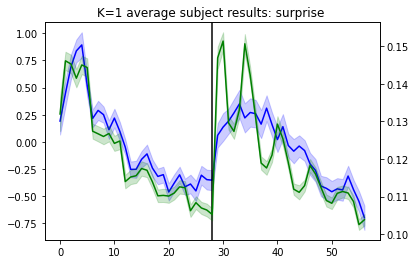

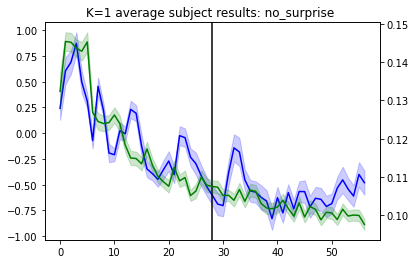

-----Statiscal tests------
with change point:  0.00011952551022977991
without change point:  0.14853429505534735
Comparison with/o change point:  0.001547751796087987


---Bootstrap results------
key:  tensor(0.8522) pm tensor(nan)
key:  tensor(0.3590) pm tensor(nan)
key:  tensor(0.4484) pm tensor(nan)
key:  tensor(0.8929) pm tensor(nan)


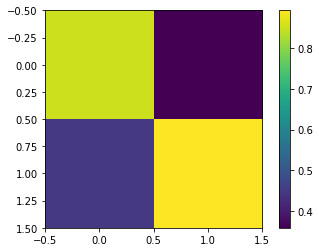


----- FOLD Number 1-----
----- FOLD Number 2-----
---Average results------
(tensor(0.8487), tensor(0.2225))
(tensor(0.2485), tensor(0.8124))


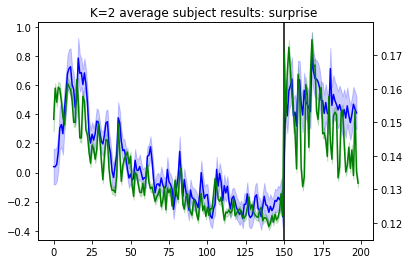

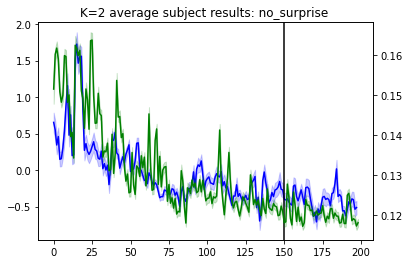

-----Statiscal tests------
with change point:  3.8979272742627943e-07
without change point:  0.3959387277886047
Comparison with/o change point:  4.0693985510808687e-05


---Bootstrap results------
key:  tensor(0.8369) pm tensor(0.0153)
key:  tensor(0.2837) pm tensor(0.0753)
key:  tensor(0.3544) pm tensor(0.0940)
key:  tensor(0.8612) pm tensor(0.0317)


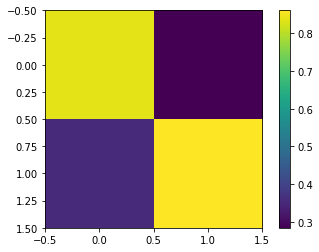

In [4]:
K=0
questionnaire = pd.read_csv('data_exp_95307-v26_questionnaire-44j4.csv',low_memory=False)
subjects = np.where(questionnaire['Event Index'].values == '1')[0]
questionnaire_frames = []
folds = 2
folds_correlations = {'stos':[],'stons':[],'nstos':[],'nstons':[]}
for trial in range(len(subjects)):
    if trial != len(subjects) -1:
        frame_tmp = questionnaire[subjects[trial]:subjects[trial+1]]
    else:
        frame_tmp = questionnaire[subjects[trial]:-1]
    frame_tmp = frame_tmp.reset_index( drop=True)
    questionnaire_frames += [frame_tmp]
for file in ['data_exp_95307-v26_task-rjpe.csv','data_exp_95307-v26_task-qsg4.csv']:
    bootstrap_matrix = torch.zeros(2,2)
    tensor = torch.load('K={0}_Exp'.format(K),map_location=torch.device('cpu'))
    frames_surprises, frames_no_surprises, max_idx, idx_vid,condition, cp = extract_frames(file)
    
    mean_sim_surprise = torch.mean((torch.reshape(torch.mean(torch.cat(tensor, dim=1)[:66],dim = 0), 
                                                  (-1, 100))), dim=1)[:int(max_idx)]
    std_sim_surprise = torch.std((torch.reshape(torch.mean(torch.cat(tensor, dim=1)[:66],dim = 0),
                                                (-1, 100))), dim=1)[:int(max_idx)] / 10
    mean_sim_no_surprise = torch.mean((torch.reshape(torch.mean(torch.cat(tensor, dim=1)[66:],dim = 0),
                                                     (-1, 100))), dim=1)[:int(max_idx)]
    std_sim_no_surprise = torch.std((torch.reshape(torch.mean(torch.cat(tensor, dim=1)[66:],dim = 0),
                                                   (-1, 100))), dim=1)[:int(max_idx)] /10
    simulations = {'surprise': mean_sim_surprise,'no_surprise': mean_sim_no_surprise}
    
    for folds_number in range(folds):
        print('----- FOLD Number {0}-----'.format(folds_number+1))
        random.shuffle(frames_surprises)
        random.shuffle(frames_no_surprises)
        if folds == 1 or folds_number == folds -1:
            n_frames = -1
        else:
            n_frames = 20
        surprises, before_surprises_cp, after_surprises_cp = average_subjects(frames_surprises[:n_frames], max_idx,
                                                   questionnaire_frames, simulations, plot = False)  
        no_surprises, before_surprises_nocp, after_surprises_nocp = average_subjects(frames_no_surprises[:n_frames], max_idx, 
                                                   questionnaire_frames, simulations, plot = False)    
        
       

        if not (folds == 1 or folds_number == folds -1):
            corrs = computes_correlation(torch.mean(surprises,axis=0),simulations)
            corrns = computes_correlation(torch.mean(no_surprises,axis=0),simulations)
            folds_correlations['stos'] += [corrs[0]]
            folds_correlations['stons'] += [corrs[1]]
            folds_correlations['nstos'] += [corrns[0]]
            folds_correlations['nstons'] += [corrns[1]]
        else:
            print('---Average results------')
            prior_cp, posterior_cp = torch.tensor(before_surprises_cp), torch.tensor(after_surprises_cp)
            prior_nocp, posterior_nocp = torch.tensor(before_surprises_nocp), torch.tensor(after_surprises_nocp)
            
            print(computes_correlation(torch.mean(surprises,axis=0),simulations))
            print(computes_correlation(torch.mean(no_surprises,axis=0),simulations))
            plot(surprises,mean_sim_surprise,std_sim_surprise,'surprise')
            plot(no_surprises,mean_sim_no_surprise,std_sim_no_surprise,'no_surprise')
            plot_ttest(prior_cp, posterior_cp,prior_nocp, posterior_nocp, K)
            print('---Bootstrap results------')
            m = 0
            for key, value in folds_correlations.items():
                x = torch.Tensor(folds_correlations[key])
                print('key: ',torch.mean(x),'pm',torch.std(x)/ math.sqrt(len(x)))
                bootstrap_matrix[m // 2,m % 2] = torch.mean(x)
                m += 1
            plt.imshow(bootstrap_matrix)
            plt.colorbar()
            plt.show()
            
            print()
    K=1